# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
from huggingface_hub import HfApi, HfFolder, Repository
import json 
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

# Data Loading

In [2]:
def loading_dataset_train(path1, path2):
    
    high = []
    low = []
    
    for sub_folder in ["high", "low"]:
        sub_path = os.path.join(path1, sub_folder)
        for file in os.listdir(sub_path):
            img_path = os.path.join(sub_path, file)
            img = Image.open(img_path)
            img = img.resize((256, 256))
            img_np = np.array(img)
            if(sub_folder == "high"):
                high.append(img_np)
            else:
                low.append(img_np)
                
    noisy_images_path = []
    gt_images_path = []
    
    instances_path = os.path.join(path2, "Scene_Instances.txt")
    with open(instances_path) as f:
        instances = f.read()
    
    instances = instances.split('\n')
    for f in instances:
        images_path = os.path.join(path2, "Data")
        images_path = os.path.join(images_path, f)

        for g in os.listdir(images_path):
            image_path = os.path.join(images_path, g)

            if 'NOISY' in image_path:
                noisy_images_path.append(image_path)
            else:
                gt_images_path.append(image_path)
                
    for img_path in noisy_images_path:
            img = Image.open(img_path)
            img = img.resize((256, 256))
            img_np = np.array(img)
            low.append(img_np)
    for img_path in gt_images_path:
            img = Image.open(img_path)
            img = img.resize((256, 256))
            img_np = np.array(img)
            high.append(img_np)
    return low, high

In [3]:
def loading_dataset_val(path1):
    
    high = []
    low = []
    
    for sub_folder in ["high", "low"]:
        sub_path = os.path.join(path1, sub_folder)
        for file in os.listdir(sub_path):
            img_path = os.path.join(sub_path, file)
            img = Image.open(img_path)
            img = img.resize((256, 256))
            img_np = np.array(img)
            if(sub_folder == "high"):
                high.append(img_np)
            else:
                low.append(img_np)
                
    return low, high

In [4]:
train_low, train_high = loading_dataset_train("/kaggle/input/lol-dataset/lol_dataset/our485", "/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only")

In [5]:
val_low, val_high = loading_dataset_val("/kaggle/input/lol-dataset/lol_dataset/eval15")

# Image Display Fucntions

In [6]:
def dis_img(img1, img2):
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1/255)
    plt.title("Low Quality Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2/255)
    plt.title("High Quality Image")
    plt.axis("off")
    
    plt.show()

In [7]:
def dis_img_test(img1, img2, img3):
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img1/255)
    plt.title("Low Quality Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(img2/255)
    plt.title("High Quality Image(Target)")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(img3/255)
    plt.title("High Quality Image(Predicted)")
    plt.axis("off")
    
    plt.show()

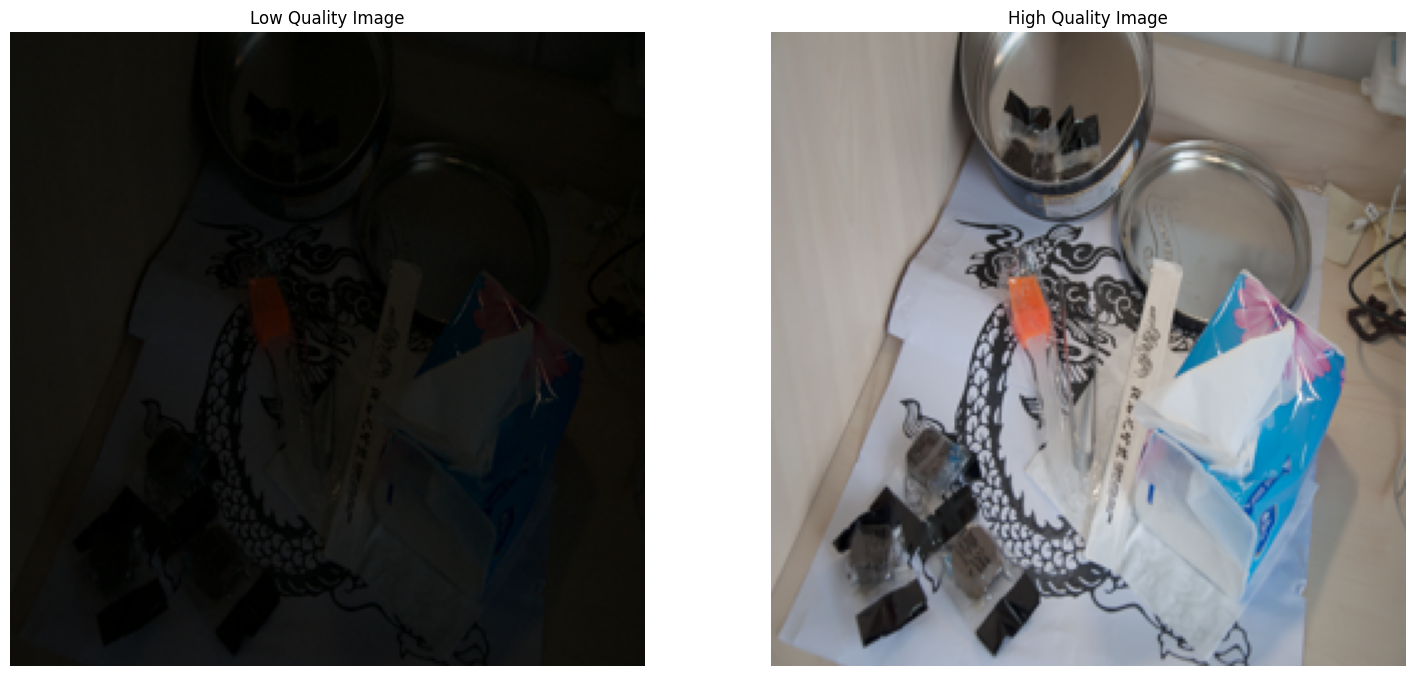

In [8]:
dis_img(train_low[40], train_high[40])

# PSNR Calculation

In [9]:
def calculate_psnr(original_img, denoised_img):
    
    original_img = original_img.astype(np.float64)
    denoised_img = denoised_img.astype(np.float64)
    
    mse = np.mean((original_img - denoised_img) ** 2)
    
    if mse == 0:
        return float('inf')
    
    max_pixel = original_img.max() - original_img.min()
    
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Creating Patches

In [10]:
def create_patches(images, patch_size=(256, 256, 3)):
    combined_patches = []

    for image in images:
        H, W, C = image.shape
        patch_height, patch_width, patch_channels = patch_size

        patches = []
        for i in range(0, H, patch_height):
            for j in range(0, W, patch_width):
                patch = image[i:i + patch_height, j:j + patch_width, :]
                patches.append(patch)

        combined_patches.extend(patches)

    return combined_patches

# Applying transform and loading the dataset into dataloader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        input_image = self.X[idx]
        denoised_image = self.y[idx]
        
        if self.transform:
            input_image = self.transform(input_image)
            denoised_image = self.transform(denoised_image)
        
        return input_image, denoised_image

In [12]:
input_transform = transforms.Compose([transforms.ToTensor()])

In [13]:
train_low_patches = create_patches(train_low)
train_high_patches = create_patches(train_high)

In [14]:
dataset = CustomDataset(train_low_patches, train_high_patches,input_transform)

In [15]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [16]:
val_dataset = CustomDataset(val_low, val_high, input_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [17]:
for batch in dataloader:
    i, j = batch
    print(f"i : {i.shape}, j : {j.shape}")
    break

i : torch.Size([32, 3, 256, 256]), j : torch.Size([32, 3, 256, 256])


# Model Architecture

In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), padding="same")
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3,3), padding="same")
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3,3), padding="same")
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2), padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        return x

In [19]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=(3,3), stride=2, padding=1, output_padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=2, padding=1, output_padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=2, padding=1, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(32, 3, kernel_size=(3,3), padding="same")
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.deconv1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.relu2(x)
        x = self.deconv3(x)
        x = self.relu3(x)
        x = self.conv(x)
        x = self.sig(x)
        return x

In [20]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
Model = Autoencoder()

# Moving the model to GPU

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
Model = Model.to(device)

# Loss and Optimizer

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=1e-3)

In [25]:
scheduler = StepLR(optimizer, step_size=25, gamma=0.9)

In [26]:
loss = []

In [27]:
epochs = 100

In [28]:
def validation(Model):
    Model.eval()
    with torch.no_grad():
        val_psnr_t = 0;
        val_min_psnr = 50
        val_max_psnr = -50
        val_loss = 0
        for batch in val_loader:
            low_img, high_img = batch
            low_img = low_img.to(device)


            denoished_img = Model(low_img)
            denoished_img = denoished_img.to("cpu")
            val_loss += criterion(denoished_img, high_img).item() 
            denoished_img = denoished_img.squeeze()
            high_img = high_img.squeeze()
            denoished_img = denoished_img.detach().numpy()
            high_img = high_img.numpy()
            denoished_img = np.transpose(denoished_img,(1,2,0))
            high_img = np.transpose(high_img,(1,2,0))
            psnr =  calculate_psnr(denoished_img, high_img)
            
            val_psnr_t += psnr
            if psnr>val_max_psnr :
                val_max_psnr = psnr
            if psnr<val_min_psnr:
                val_min_psnr = psnr

        val_psnr_t /= len(val_loader)
        val_loss /= len(val_loader)
        return val_loss, val_psnr_t

In [29]:
def training(Model):
    Model.eval()
    with torch.no_grad():
        train_psnr_t = 0;
        train_min_psnr = 50
        train_max_psnr = -50
        train_loss = 0
        for batch in dataloader:
            low_imgs, high_imgs = batch
            low_imgs = low_imgs.to(device)

            denoished_imgs = Model(low_imgs)
            denoished_imgs = denoished_imgs.to("cpu")
            train_loss += criterion(denoished_imgs, high_imgs).item() 
            batch_psnr_sum = 0
            for i in range(denoished_imgs.shape[0]):
                denoished_img = denoished_imgs[i]
                high_img = high_imgs[i]
                denoished_img = denoished_img.detach().numpy()
                high_img = high_img.numpy()
                denoished_img = np.transpose(denoished_img,(1,2,0))
                high_img = np.transpose(high_img,(1,2,0))
                psnr =  calculate_psnr(denoished_img, high_img)

                batch_psnr_sum += psnr
                if psnr>train_max_psnr :
                    train_max_psnr = psnr
                if psnr<train_min_psnr:
                    train_min_psnr = psnr
            
            train_psnr_t += batch_psnr_sum / denoished_imgs.shape[0]

        train_psnr_t /= len(dataloader)
        train_loss /= len(dataloader)
        return train_loss, train_psnr_t

# Model Training

In [30]:
for epoch in range(epochs):
    loss_e = 0
    for batch in tqdm(dataloader):
        Model.train()
        optimizer.zero_grad()
        
        low_img, high_img = batch
        low_img = low_img.to(device)
        high_img = high_img.to(device)
        
        denoished_img = Model(low_img)
        
        error = criterion(denoished_img, high_img) 
        
        error.backward()
        optimizer.step()
        loss_e += error.item()

    scheduler.step()
    loss_e /= len(dataloader)
    loss.append(loss_e)
    val_loss, val_psnr = validation(Model)
    train_loss, train_psnr = training(Model)
    print(f"{epoch+1} / {epochs} Runnung Training loss : {loss_e}")
    print(f"Training loss : {train_loss:.4f} Training PSNR : {train_psnr:.4f} Validation Loss : {val_loss:.4f} Validation PSNR : {val_psnr:.4f}")

  0%|          | 0/21 [00:00<?, ?it/s]

1 / 100 Runnung Training loss : 0.053728854727177394
Training loss : 0.0503 Training PSNR : -4.7163 Validation Loss : 0.0558 Validation PSNR : -4.8617


  0%|          | 0/21 [00:00<?, ?it/s]

2 / 100 Runnung Training loss : 0.05045031827120554
Training loss : 0.0488 Training PSNR : -2.7377 Validation Loss : 0.0540 Validation PSNR : -2.7095


  0%|          | 0/21 [00:00<?, ?it/s]

3 / 100 Runnung Training loss : 0.0463739252161412
Training loss : 0.0442 Training PSNR : 0.9231 Validation Loss : 0.0451 Validation PSNR : 0.8887


  0%|          | 0/21 [00:00<?, ?it/s]

4 / 100 Runnung Training loss : 0.04272303499636196
Training loss : 0.0419 Training PSNR : 3.0612 Validation Loss : 0.0444 Validation PSNR : 1.4735


  0%|          | 0/21 [00:00<?, ?it/s]

5 / 100 Runnung Training loss : 0.04063865879461879
Training loss : 0.0376 Training PSNR : 5.7900 Validation Loss : 0.0404 Validation PSNR : 4.4670


  0%|          | 0/21 [00:00<?, ?it/s]

6 / 100 Runnung Training loss : 0.03873840444499538
Training loss : 0.0404 Training PSNR : 3.1612 Validation Loss : 0.0439 Validation PSNR : 1.8232


  0%|          | 0/21 [00:00<?, ?it/s]

7 / 100 Runnung Training loss : 0.03779265284538269
Training loss : 0.0426 Training PSNR : 7.2694 Validation Loss : 0.0439 Validation PSNR : 6.4218


  0%|          | 0/21 [00:00<?, ?it/s]

8 / 100 Runnung Training loss : 0.037211189489989055
Training loss : 0.0342 Training PSNR : 7.9874 Validation Loss : 0.0351 Validation PSNR : 7.0608


  0%|          | 0/21 [00:00<?, ?it/s]

9 / 100 Runnung Training loss : 0.03442117846792653
Training loss : 0.0348 Training PSNR : 8.6561 Validation Loss : 0.0323 Validation PSNR : 8.7471


  0%|          | 0/21 [00:00<?, ?it/s]

10 / 100 Runnung Training loss : 0.03400704867783047
Training loss : 0.0330 Training PSNR : 9.5555 Validation Loss : 0.0305 Validation PSNR : 9.4605


  0%|          | 0/21 [00:00<?, ?it/s]

11 / 100 Runnung Training loss : 0.034115262950460114
Training loss : 0.0333 Training PSNR : 10.4784 Validation Loss : 0.0298 Validation PSNR : 10.5889


  0%|          | 0/21 [00:00<?, ?it/s]

12 / 100 Runnung Training loss : 0.03221478011636507
Training loss : 0.0324 Training PSNR : 10.5955 Validation Loss : 0.0303 Validation PSNR : 10.4968


  0%|          | 0/21 [00:00<?, ?it/s]

13 / 100 Runnung Training loss : 0.03288049064576626
Training loss : 0.0298 Training PSNR : 11.1588 Validation Loss : 0.0278 Validation PSNR : 11.2035


  0%|          | 0/21 [00:00<?, ?it/s]

14 / 100 Runnung Training loss : 0.03390783807706265
Training loss : 0.0321 Training PSNR : 10.9086 Validation Loss : 0.0331 Validation PSNR : 10.1190


  0%|          | 0/21 [00:00<?, ?it/s]

15 / 100 Runnung Training loss : 0.03193273492867038
Training loss : 0.0298 Training PSNR : 11.5681 Validation Loss : 0.0296 Validation PSNR : 11.1633


  0%|          | 0/21 [00:00<?, ?it/s]

16 / 100 Runnung Training loss : 0.03146274937760262
Training loss : 0.0302 Training PSNR : 11.0727 Validation Loss : 0.0302 Validation PSNR : 10.7823


  0%|          | 0/21 [00:00<?, ?it/s]

17 / 100 Runnung Training loss : 0.030072231289176715
Training loss : 0.0285 Training PSNR : 12.4566 Validation Loss : 0.0277 Validation PSNR : 12.2839


  0%|          | 0/21 [00:00<?, ?it/s]

18 / 100 Runnung Training loss : 0.028620138941776185
Training loss : 0.0287 Training PSNR : 12.0804 Validation Loss : 0.0289 Validation PSNR : 11.8927


  0%|          | 0/21 [00:00<?, ?it/s]

19 / 100 Runnung Training loss : 0.028776343557096663
Training loss : 0.0304 Training PSNR : 11.8815 Validation Loss : 0.0345 Validation PSNR : 10.7727


  0%|          | 0/21 [00:00<?, ?it/s]

20 / 100 Runnung Training loss : 0.028763955636393456
Training loss : 0.0340 Training PSNR : 12.3706 Validation Loss : 0.0334 Validation PSNR : 12.3863


  0%|          | 0/21 [00:00<?, ?it/s]

21 / 100 Runnung Training loss : 0.030542738558281036
Training loss : 0.0276 Training PSNR : 12.5166 Validation Loss : 0.0283 Validation PSNR : 12.0717


  0%|          | 0/21 [00:00<?, ?it/s]

22 / 100 Runnung Training loss : 0.028216393753176645
Training loss : 0.0288 Training PSNR : 13.2123 Validation Loss : 0.0276 Validation PSNR : 13.4120


  0%|          | 0/21 [00:00<?, ?it/s]

23 / 100 Runnung Training loss : 0.029129963811664356
Training loss : 0.0282 Training PSNR : 12.8123 Validation Loss : 0.0287 Validation PSNR : 12.5523


  0%|          | 0/21 [00:00<?, ?it/s]

24 / 100 Runnung Training loss : 0.02754935347253368
Training loss : 0.0300 Training PSNR : 13.0901 Validation Loss : 0.0283 Validation PSNR : 13.3545


  0%|          | 0/21 [00:00<?, ?it/s]

25 / 100 Runnung Training loss : 0.02781981212042627
Training loss : 0.0271 Training PSNR : 12.7013 Validation Loss : 0.0286 Validation PSNR : 12.4321


  0%|          | 0/21 [00:00<?, ?it/s]

26 / 100 Runnung Training loss : 0.027182583031909808
Training loss : 0.0271 Training PSNR : 12.6949 Validation Loss : 0.0294 Validation PSNR : 12.1577


  0%|          | 0/21 [00:00<?, ?it/s]

27 / 100 Runnung Training loss : 0.02676904449860255
Training loss : 0.0263 Training PSNR : 13.2427 Validation Loss : 0.0261 Validation PSNR : 13.2592


  0%|          | 0/21 [00:00<?, ?it/s]

28 / 100 Runnung Training loss : 0.026206819251889273
Training loss : 0.0277 Training PSNR : 13.4850 Validation Loss : 0.0279 Validation PSNR : 13.5660


  0%|          | 0/21 [00:00<?, ?it/s]

29 / 100 Runnung Training loss : 0.028039793616959026
Training loss : 0.0262 Training PSNR : 13.2015 Validation Loss : 0.0274 Validation PSNR : 12.9821


  0%|          | 0/21 [00:00<?, ?it/s]

30 / 100 Runnung Training loss : 0.027549684136396364
Training loss : 0.0256 Training PSNR : 13.7583 Validation Loss : 0.0257 Validation PSNR : 13.7238


  0%|          | 0/21 [00:00<?, ?it/s]

31 / 100 Runnung Training loss : 0.026948245685724986
Training loss : 0.0255 Training PSNR : 14.3709 Validation Loss : 0.0265 Validation PSNR : 14.4029


  0%|          | 0/21 [00:00<?, ?it/s]

32 / 100 Runnung Training loss : 0.025633628701879865
Training loss : 0.0272 Training PSNR : 13.8741 Validation Loss : 0.0308 Validation PSNR : 13.0385


  0%|          | 0/21 [00:00<?, ?it/s]

33 / 100 Runnung Training loss : 0.0266342085032236
Training loss : 0.0250 Training PSNR : 13.4569 Validation Loss : 0.0265 Validation PSNR : 13.3244


  0%|          | 0/21 [00:00<?, ?it/s]

34 / 100 Runnung Training loss : 0.026595161784262883
Training loss : 0.0248 Training PSNR : 13.9715 Validation Loss : 0.0269 Validation PSNR : 13.6911


  0%|          | 0/21 [00:00<?, ?it/s]

35 / 100 Runnung Training loss : 0.024762055481828395
Training loss : 0.0239 Training PSNR : 14.5488 Validation Loss : 0.0264 Validation PSNR : 14.3548


  0%|          | 0/21 [00:00<?, ?it/s]

36 / 100 Runnung Training loss : 0.024730640862669264
Training loss : 0.0244 Training PSNR : 14.4628 Validation Loss : 0.0261 Validation PSNR : 14.4613


  0%|          | 0/21 [00:00<?, ?it/s]

37 / 100 Runnung Training loss : 0.025046845188453085
Training loss : 0.0247 Training PSNR : 14.0703 Validation Loss : 0.0279 Validation PSNR : 13.6397


  0%|          | 0/21 [00:00<?, ?it/s]

38 / 100 Runnung Training loss : 0.023791396635628882
Training loss : 0.0248 Training PSNR : 14.5094 Validation Loss : 0.0260 Validation PSNR : 14.3289


  0%|          | 0/21 [00:00<?, ?it/s]

39 / 100 Runnung Training loss : 0.02395130250425566
Training loss : 0.0366 Training PSNR : 13.0091 Validation Loss : 0.0408 Validation PSNR : 12.2472


  0%|          | 0/21 [00:00<?, ?it/s]

40 / 100 Runnung Training loss : 0.02530596808840831
Training loss : 0.0253 Training PSNR : 14.3254 Validation Loss : 0.0280 Validation PSNR : 13.6683


  0%|          | 0/21 [00:00<?, ?it/s]

41 / 100 Runnung Training loss : 0.025104987479391553
Training loss : 0.0254 Training PSNR : 13.6622 Validation Loss : 0.0300 Validation PSNR : 12.8933


  0%|          | 0/21 [00:00<?, ?it/s]

42 / 100 Runnung Training loss : 0.02441606031996863
Training loss : 0.0246 Training PSNR : 14.4407 Validation Loss : 0.0255 Validation PSNR : 14.4026


  0%|          | 0/21 [00:00<?, ?it/s]

43 / 100 Runnung Training loss : 0.025323179727863698
Training loss : 0.0239 Training PSNR : 14.5883 Validation Loss : 0.0272 Validation PSNR : 14.2330


  0%|          | 0/21 [00:00<?, ?it/s]

44 / 100 Runnung Training loss : 0.024936148630721227
Training loss : 0.0239 Training PSNR : 14.7171 Validation Loss : 0.0261 Validation PSNR : 14.2657


  0%|          | 0/21 [00:00<?, ?it/s]

45 / 100 Runnung Training loss : 0.024244913920050577
Training loss : 0.0222 Training PSNR : 14.8639 Validation Loss : 0.0243 Validation PSNR : 14.6805


  0%|          | 0/21 [00:00<?, ?it/s]

46 / 100 Runnung Training loss : 0.023435746097848528
Training loss : 0.0310 Training PSNR : 13.8583 Validation Loss : 0.0389 Validation PSNR : 12.5455


  0%|          | 0/21 [00:00<?, ?it/s]

47 / 100 Runnung Training loss : 0.02710721588560513
Training loss : 0.0232 Training PSNR : 14.2415 Validation Loss : 0.0253 Validation PSNR : 13.9048


  0%|          | 0/21 [00:00<?, ?it/s]

48 / 100 Runnung Training loss : 0.024019379612235797
Training loss : 0.0288 Training PSNR : 14.0294 Validation Loss : 0.0348 Validation PSNR : 12.8492


  0%|          | 0/21 [00:00<?, ?it/s]

49 / 100 Runnung Training loss : 0.023585831835156397
Training loss : 0.0222 Training PSNR : 15.3801 Validation Loss : 0.0251 Validation PSNR : 14.8356


  0%|          | 0/21 [00:00<?, ?it/s]

50 / 100 Runnung Training loss : 0.02223304472863674
Training loss : 0.0235 Training PSNR : 14.6749 Validation Loss : 0.0256 Validation PSNR : 14.6396


  0%|          | 0/21 [00:00<?, ?it/s]

51 / 100 Runnung Training loss : 0.022366631066515333
Training loss : 0.0215 Training PSNR : 15.0076 Validation Loss : 0.0261 Validation PSNR : 14.1758


  0%|          | 0/21 [00:00<?, ?it/s]

52 / 100 Runnung Training loss : 0.02231009535136677
Training loss : 0.0214 Training PSNR : 15.1269 Validation Loss : 0.0243 Validation PSNR : 14.6856


  0%|          | 0/21 [00:00<?, ?it/s]

53 / 100 Runnung Training loss : 0.023787900007196834
Training loss : 0.0245 Training PSNR : 14.6417 Validation Loss : 0.0282 Validation PSNR : 13.7271


  0%|          | 0/21 [00:00<?, ?it/s]

54 / 100 Runnung Training loss : 0.02295836043499765
Training loss : 0.0240 Training PSNR : 14.8906 Validation Loss : 0.0298 Validation PSNR : 13.5381


  0%|          | 0/21 [00:00<?, ?it/s]

55 / 100 Runnung Training loss : 0.023452662552396458
Training loss : 0.0212 Training PSNR : 15.2402 Validation Loss : 0.0249 Validation PSNR : 14.6285


  0%|          | 0/21 [00:00<?, ?it/s]

56 / 100 Runnung Training loss : 0.022128197719298658
Training loss : 0.0220 Training PSNR : 15.1627 Validation Loss : 0.0234 Validation PSNR : 15.0525


  0%|          | 0/21 [00:00<?, ?it/s]

57 / 100 Runnung Training loss : 0.022656133575808434
Training loss : 0.0217 Training PSNR : 14.9025 Validation Loss : 0.0240 Validation PSNR : 14.5441


  0%|          | 0/21 [00:00<?, ?it/s]

58 / 100 Runnung Training loss : 0.020755052832620486
Training loss : 0.0207 Training PSNR : 15.6562 Validation Loss : 0.0250 Validation PSNR : 14.7300


  0%|          | 0/21 [00:00<?, ?it/s]

59 / 100 Runnung Training loss : 0.02096047398767301
Training loss : 0.0212 Training PSNR : 15.5170 Validation Loss : 0.0257 Validation PSNR : 14.4563


  0%|          | 0/21 [00:00<?, ?it/s]

60 / 100 Runnung Training loss : 0.021442616801886333
Training loss : 0.0221 Training PSNR : 15.0060 Validation Loss : 0.0243 Validation PSNR : 14.7567


  0%|          | 0/21 [00:00<?, ?it/s]

61 / 100 Runnung Training loss : 0.021744924907883007
Training loss : 0.0202 Training PSNR : 15.9694 Validation Loss : 0.0235 Validation PSNR : 15.3233


  0%|          | 0/21 [00:00<?, ?it/s]

62 / 100 Runnung Training loss : 0.021525512493792035
Training loss : 0.0205 Training PSNR : 15.0535 Validation Loss : 0.0257 Validation PSNR : 14.0302


  0%|          | 0/21 [00:00<?, ?it/s]

63 / 100 Runnung Training loss : 0.020605850876087232
Training loss : 0.0219 Training PSNR : 14.7735 Validation Loss : 0.0265 Validation PSNR : 13.7720


  0%|          | 0/21 [00:00<?, ?it/s]

64 / 100 Runnung Training loss : 0.0216195961194379
Training loss : 0.0206 Training PSNR : 15.1382 Validation Loss : 0.0245 Validation PSNR : 14.2394


  0%|          | 0/21 [00:00<?, ?it/s]

65 / 100 Runnung Training loss : 0.020142031877878167
Training loss : 0.0205 Training PSNR : 15.5106 Validation Loss : 0.0255 Validation PSNR : 14.5471


  0%|          | 0/21 [00:00<?, ?it/s]

66 / 100 Runnung Training loss : 0.02078710465381543
Training loss : 0.0201 Training PSNR : 15.5711 Validation Loss : 0.0254 Validation PSNR : 14.5177


  0%|          | 0/21 [00:00<?, ?it/s]

67 / 100 Runnung Training loss : 0.021098862269095013
Training loss : 0.0208 Training PSNR : 15.3519 Validation Loss : 0.0247 Validation PSNR : 14.4132


  0%|          | 0/21 [00:00<?, ?it/s]

68 / 100 Runnung Training loss : 0.021195920184254646
Training loss : 0.0228 Training PSNR : 14.6368 Validation Loss : 0.0255 Validation PSNR : 14.2371


  0%|          | 0/21 [00:00<?, ?it/s]

69 / 100 Runnung Training loss : 0.0213457898547252
Training loss : 0.0226 Training PSNR : 14.9972 Validation Loss : 0.0256 Validation PSNR : 14.5448


  0%|          | 0/21 [00:00<?, ?it/s]

70 / 100 Runnung Training loss : 0.023863073881892932
Training loss : 0.0225 Training PSNR : 15.0198 Validation Loss : 0.0262 Validation PSNR : 14.2418


  0%|          | 0/21 [00:00<?, ?it/s]

71 / 100 Runnung Training loss : 0.02100870350287074
Training loss : 0.0200 Training PSNR : 15.8000 Validation Loss : 0.0239 Validation PSNR : 15.0250


  0%|          | 0/21 [00:00<?, ?it/s]

72 / 100 Runnung Training loss : 0.021052734305461247
Training loss : 0.0220 Training PSNR : 15.3816 Validation Loss : 0.0256 Validation PSNR : 14.8043


  0%|          | 0/21 [00:00<?, ?it/s]

73 / 100 Runnung Training loss : 0.021013893408789522
Training loss : 0.0196 Training PSNR : 15.9252 Validation Loss : 0.0241 Validation PSNR : 15.1322


  0%|          | 0/21 [00:00<?, ?it/s]

74 / 100 Runnung Training loss : 0.019478732187833105
Training loss : 0.0194 Training PSNR : 15.9807 Validation Loss : 0.0235 Validation PSNR : 15.0268


  0%|          | 0/21 [00:00<?, ?it/s]

75 / 100 Runnung Training loss : 0.01972576825036889
Training loss : 0.0190 Training PSNR : 15.7400 Validation Loss : 0.0257 Validation PSNR : 14.3985


  0%|          | 0/21 [00:00<?, ?it/s]

76 / 100 Runnung Training loss : 0.019238691244806563
Training loss : 0.0183 Training PSNR : 16.2961 Validation Loss : 0.0233 Validation PSNR : 15.1697


  0%|          | 0/21 [00:00<?, ?it/s]

77 / 100 Runnung Training loss : 0.020022170307735603
Training loss : 0.0211 Training PSNR : 15.5996 Validation Loss : 0.0267 Validation PSNR : 14.1769


  0%|          | 0/21 [00:00<?, ?it/s]

78 / 100 Runnung Training loss : 0.023313240103778384
Training loss : 0.0206 Training PSNR : 15.4343 Validation Loss : 0.0230 Validation PSNR : 14.8578


  0%|          | 0/21 [00:00<?, ?it/s]

79 / 100 Runnung Training loss : 0.020344481493035953
Training loss : 0.0194 Training PSNR : 15.7817 Validation Loss : 0.0251 Validation PSNR : 14.7393


  0%|          | 0/21 [00:00<?, ?it/s]

80 / 100 Runnung Training loss : 0.019485312647053173
Training loss : 0.0202 Training PSNR : 15.6417 Validation Loss : 0.0258 Validation PSNR : 14.6357


  0%|          | 0/21 [00:00<?, ?it/s]

81 / 100 Runnung Training loss : 0.020225217654591517
Training loss : 0.0186 Training PSNR : 16.0569 Validation Loss : 0.0250 Validation PSNR : 14.6714


  0%|          | 0/21 [00:00<?, ?it/s]

82 / 100 Runnung Training loss : 0.01897186471060628
Training loss : 0.0200 Training PSNR : 16.2651 Validation Loss : 0.0230 Validation PSNR : 15.6767


  0%|          | 0/21 [00:00<?, ?it/s]

83 / 100 Runnung Training loss : 0.02020929332467772
Training loss : 0.0193 Training PSNR : 16.3226 Validation Loss : 0.0226 Validation PSNR : 15.4521


  0%|          | 0/21 [00:00<?, ?it/s]

84 / 100 Runnung Training loss : 0.019548164325810614
Training loss : 0.0187 Training PSNR : 15.9686 Validation Loss : 0.0218 Validation PSNR : 15.0184


  0%|          | 0/21 [00:00<?, ?it/s]

85 / 100 Runnung Training loss : 0.01835956380126022
Training loss : 0.0179 Training PSNR : 16.1867 Validation Loss : 0.0231 Validation PSNR : 14.6797


  0%|          | 0/21 [00:00<?, ?it/s]

86 / 100 Runnung Training loss : 0.018647157675808386
Training loss : 0.0195 Training PSNR : 16.1598 Validation Loss : 0.0239 Validation PSNR : 15.3491


  0%|          | 0/21 [00:00<?, ?it/s]

87 / 100 Runnung Training loss : 0.01837397020842348
Training loss : 0.0183 Training PSNR : 16.3230 Validation Loss : 0.0237 Validation PSNR : 15.0093


  0%|          | 0/21 [00:00<?, ?it/s]

88 / 100 Runnung Training loss : 0.019218080100559053
Training loss : 0.0217 Training PSNR : 15.2475 Validation Loss : 0.0260 Validation PSNR : 14.5741


  0%|          | 0/21 [00:00<?, ?it/s]

89 / 100 Runnung Training loss : 0.019454597096358026
Training loss : 0.0182 Training PSNR : 16.2760 Validation Loss : 0.0229 Validation PSNR : 15.0399


  0%|          | 0/21 [00:00<?, ?it/s]

90 / 100 Runnung Training loss : 0.01820118889390003
Training loss : 0.0186 Training PSNR : 16.1777 Validation Loss : 0.0227 Validation PSNR : 15.0667


  0%|          | 0/21 [00:00<?, ?it/s]

91 / 100 Runnung Training loss : 0.01989901287569886
Training loss : 0.0182 Training PSNR : 15.8268 Validation Loss : 0.0240 Validation PSNR : 14.3072


  0%|          | 0/21 [00:00<?, ?it/s]

92 / 100 Runnung Training loss : 0.018994043137700783
Training loss : 0.0181 Training PSNR : 16.2451 Validation Loss : 0.0223 Validation PSNR : 15.2677


  0%|          | 0/21 [00:00<?, ?it/s]

93 / 100 Runnung Training loss : 0.01781443621785868
Training loss : 0.0176 Training PSNR : 16.5169 Validation Loss : 0.0220 Validation PSNR : 15.2899


  0%|          | 0/21 [00:00<?, ?it/s]

94 / 100 Runnung Training loss : 0.017563239338674715
Training loss : 0.0224 Training PSNR : 15.7302 Validation Loss : 0.0244 Validation PSNR : 15.6258


  0%|          | 0/21 [00:00<?, ?it/s]

95 / 100 Runnung Training loss : 0.019244362821891195
Training loss : 0.0206 Training PSNR : 15.8187 Validation Loss : 0.0229 Validation PSNR : 15.4840


  0%|          | 0/21 [00:00<?, ?it/s]

96 / 100 Runnung Training loss : 0.01952738957923083
Training loss : 0.0194 Training PSNR : 16.0062 Validation Loss : 0.0211 Validation PSNR : 15.6402


  0%|          | 0/21 [00:00<?, ?it/s]

97 / 100 Runnung Training loss : 0.019281237120074884
Training loss : 0.0196 Training PSNR : 16.5242 Validation Loss : 0.0211 Validation PSNR : 16.1533


  0%|          | 0/21 [00:00<?, ?it/s]

98 / 100 Runnung Training loss : 0.018164726195945627
Training loss : 0.0172 Training PSNR : 16.9296 Validation Loss : 0.0227 Validation PSNR : 15.7931


  0%|          | 0/21 [00:00<?, ?it/s]

99 / 100 Runnung Training loss : 0.01825718776810737
Training loss : 0.0190 Training PSNR : 16.2826 Validation Loss : 0.0230 Validation PSNR : 15.6020


  0%|          | 0/21 [00:00<?, ?it/s]

100 / 100 Runnung Training loss : 0.018339452023307484
Training loss : 0.0184 Training PSNR : 16.4439 Validation Loss : 0.0238 Validation PSNR : 15.4001


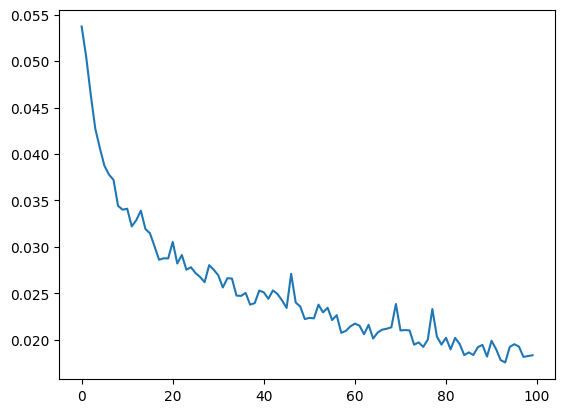

In [31]:
plt.plot(loss)
plt.show()

# Comparing a single image

In [32]:
h = Image.open("/kaggle/input/lol-dataset/lol_dataset/eval15/high/1.png")
h = h.resize((256, 256))
l = Image.open("/kaggle/input/lol-dataset/lol_dataset/eval15/low/1.png")
l = l.resize((256,256))
h = input_transform(h)
l = input_transform(l)

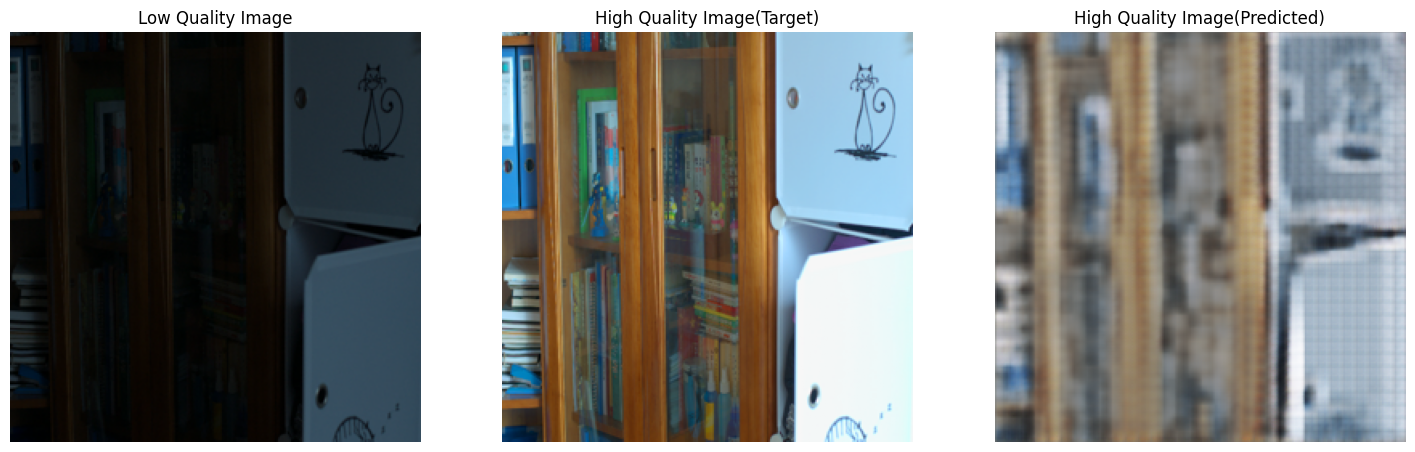

13.5489643276967
-0.06420559036991744


In [33]:
Model.eval()
i = l.unsqueeze(0)
i = i.to(device)
d = Model(i)
d = d.to("cpu")
d = d.squeeze()
d = d.detach().numpy()
d = np.transpose(d,(1,2,0))
l = np.transpose(l.numpy(),(1,2,0))
h = np.transpose(h.numpy(),(1,2,0))
dis_img_test(l*255, h*255, d*255,)
psnr =  calculate_psnr(d, h)
print(psnr)
psnr = calculate_psnr(l, h)
print(psnr)

# Uploading the model to huggingface

In [34]:
model = Model.to("cpu")

In [35]:
token = "hugging_face_token"
HfFolder.save_token(token)

In [36]:
api = HfApi()
repo_id = "vaibhavprajapati22/Image_Denoising_Autoencoder"  
api.create_repo(repo_id=repo_id, repo_type="model", token=token, exist_ok=True)

RepoUrl('https://huggingface.co/vaibhavprajapati22/Image_Denoising_Autoencoder', endpoint='https://huggingface.co', repo_type='model', repo_id='vaibhavprajapati22/Image_Denoising_Autoencoder')

In [37]:
output_dir = "./Image_Denoising_Autoencoder"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
torch.save(model.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

In [38]:
config = {
    "architecture": "Autoencoder",
    "input_channels": 3,
    "output_channels": 3,
    "layers": [
        {"type": "Conv2d", "in_channels": 3, "out_channels": 32, "kernel_size": [3, 3], "padding": "same"},
        {"type": "ReLU", "inplace": True},
        {"type": "MaxPool2d", "kernel_size": [2, 2], "padding": 0},
        {"type": "Conv2d", "in_channels": 32, "out_channels": 64, "kernel_size": [3, 3], "padding": "same"},
        {"type": "ReLU", "inplace": True},
        {"type": "MaxPool2d", "kernel_size": [2, 2], "padding": 0},
        {"type": "Conv2d", "in_channels": 64, "out_channels": 128, "kernel_size": [3, 3], "padding": "same"},
        {"type": "ReLU", "inplace": True},
        {"type": "MaxPool2d", "kernel_size": [2, 2], "padding": 0},
        {"type": "ConvTranspose2d", "in_channels": 128, "out_channels": 128, "kernel_size": [3, 3], "stride": 2, "padding": 1, "output_padding": 1},
        {"type": "ReLU", "inplace": True},
        {"type": "ConvTranspose2d", "in_channels": 128, "out_channels": 64, "kernel_size": [3, 3], "stride": 2, "padding": 1, "output_padding": 1},
        {"type": "ReLU", "inplace": True},
        {"type": "ConvTranspose2d", "in_channels": 64, "out_channels": 32, "kernel_size": [3, 3], "stride": 2, "padding": 1, "output_padding": 1},
        {"type": "ReLU", "inplace": True},
        {"type": "Conv2d", "in_channels": 32, "out_channels": 3, "kernel_size": [3, 3], "padding": "same"},
        {"type": "Sigmoid"}
    ]
}
with open(os.path.join(output_dir, "config.json"), 'w') as f:
    json.dump(config, f)

In [39]:
readme = """
---
language: en
tags:
- image-processing
- image-denoising
- deep-learning
license: apache-2.0
model_name: Image Denoising Model
---

# Autoencoder Model 

This Repo contains the weights and config of Autoencoder Model that can be used for image denoising.

# Datasets

- LOL Dataset
- Smartphone Image Denoising Dataset

# References
https://keras.io/examples/vision/autoencoder/

"""
with open(os.path.join(output_dir, "README.md"), 'w') as f:
    f.write(readme)

In [40]:
api.upload_folder(
    folder_path=output_dir,
    repo_id=repo_id,
    repo_type="model",
    commit_message="Initial commit",
    token=token
)

print(f"Model successfully uploaded to https://huggingface.co/{repo_id}")

pytorch_model.bin:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Model successfully uploaded to https://huggingface.co/vaibhavprajapati22/Image_Denoising_Autoencoder
